In [1]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator

from mne.io import read_raw_fif
from mne_bids import BIDSPath
from nilearn.plotting import plot_markers

from scipy import stats
from scipy import signal
from scipy.io import wavfile
from scipy.stats import zscore

plt.style.use("figures.mplstyle")
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 6

# figure 1

## brain map

In [ ]:
# get coords
edf_path = BIDSPath(root="../../monkey/derivatives/ecogprep", datatype="ieeg", description="highgamma", extension=".fif")

all_coords = []
for raw_fif in edf_path.match():
    print(raw_fif)
    raw = read_raw_fif(raw_fif, verbose=False)
    ch2loc = {ch['ch_name']: ch['loc'][:3] for ch in raw.info['chs']}
    sub_coords = np.vstack([ch2loc[ch] for ch in raw.info['ch_names']])

    all_coords.append(sub_coords)

In [ ]:
# elec_sub = [np.full(len(c), fill_value=i) for i, c in enumerate(all_coords)]
elec_sub = [len(c) for i, c in enumerate(all_coords)]
elec_sub

In [ ]:
coords = np.vstack(all_coords) * 1000
values = np.ones(len(coords))
values.shape, coords.shape

In [ ]:
fig, ax = plt.subplots(dpi=300)
plot_markers(values, coords,
             node_size=10, display_mode='lyr',
            #  node_cmap='tab10',
             node_cmap='Grays',
             colorbar=not True,
             node_kwargs=dict(edgecolors='none'),
             alpha=0.5, node_vmin=0,
             figure=fig, axes=ax)
fig.savefig("../figures/figure1/viz-brain.svg")                
fig.show()

## audio

In [ ]:
audio_path = "../../monkey/stimuli/monkey.wav"
# audio_path = "../../pieman/stimuli/pieman.wav"
highfs, highqa = wavfile.read(audio_path)
highqa = highqa[:, 0]

In [ ]:
to_fs = 100
y = signal.resample(highqa, num=round(highqa.size / highfs * to_fs))
y.shape

In [8]:
y = signal.detrend(y, type='constant')
y = stats.zscore(y)
y = np.clip(y, -5, 5)

xaxis = np.arange(y.size) / to_fs / 60

In [ ]:
audio_wav = y

fig, ax = plt.subplots(figsize=(7.25, .75))
ax.plot(xaxis, audio_wav, c='k')

ax.set_xlim(0, 30)
ax.set_xlabel("time (min)")

ax.set_yticks([])
for spine in ['left', 'top', 'right']:
    ax.spines[spine].set_visible(False)

ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))

fig.savefig("../figures/figure1/viz-audio.svg", bbox_inches='tight', pad_inches=0)
fig.show()

# example brain data

In [ ]:
channels = ['LGA10', 'DRPI1', 'LGA37']

edf_path = BIDSPath(
    root="../../monkey/derivatives/ecogprep",
    subject="03",
    datatype="ieeg",
    description="highgamma",
    extension=".fif",
)

edf_path = edf_path.match()[0]

raw = mne.io.read_raw_fif(edf_path)
raw = raw.pick(channels)
raw = raw.resample(100)
raw

In [ ]:
raw_data = raw.get_data()
raw_data.shape

In [12]:
xaxis = np.arange(raw_data.shape[1]) / raw.info['sfreq'] / 60

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(7.25, 1.5), sharex=False, sharey=True)
for i, ax in enumerate(axes):
    ax.plot(xaxis, stats.zscore(raw_data[i]), c='k', lw=.5)
    ax.set_xlim(0, 30)

    if i < len(axes) - 1:
        ax.set_yticks([])
        ax.set_xticks([])
        ax.spines['bottom'].set_visible(False)

    for spine in ['left', 'top', 'right']:
        ax.spines[spine].set_visible(False)

    ax.axvspan(21.216 / 60, 22.377 / 60)

ax.set_xlabel("time (min)")
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))

fig.savefig("../figures/figure1/viz-elec-time-series.svg", bbox_inches='tight', pad_inches=0)
fig.show()

# transcript

In [ ]:
audio_path = "../../monkey/stimuli/monkey.wav"
highfs, highqa = wavfile.read(audio_path)
highqa = highqa[:, 0] 

In [ ]:
df = pd.read_csv("../../monkey/stimuli/monkey_util-whisperx_transcript.csv")

subdf = df.iloc[47:54]
subdf

In [ ]:
subdf_start = int(subdf.start.iloc[0] * highfs)
subdf_end = int(subdf.end.iloc[-1] * highfs)
subdf_wav = zscore(highqa[subdf_start : subdf_end])
subdf_wav.shape

In [ ]:
fig, ax = plt.subplots(figsize=(3.75, 0.5))

start = subdf.start.iloc[0]
for _, row in subdf.iterrows():
    ax.text(row.start, y=5, s=row.word, rotation=24, fontsize=6)

ax.set_xlim(21.2 - .05, 22.6 + .05)
ax.xaxis.set_major_formatter('{x:.1f}')

ax.set_ylim(-7, 7)
ax.set_xlabel("time (s)")

xaxis = np.arange(len(subdf_wav)) / highfs + start
ax.plot(xaxis, subdf_wav, c='k')

# cleanup
ax.set_yticks([])
for spine in ['left', 'top', 'right']:
    ax.spines[spine].set_visible(False)

fig.savefig("../figures/figure1/viz-word-timing.svg")
fig.show()

In [ ]:
subdf = df.iloc[4454:4462]
subdf

In [ ]:
subdf_start = int(subdf.start.iloc[0] * highfs)
subdf_end = int(subdf.end.iloc[-1] * highfs)
subdf_wav = zscore(highqa[subdf_start : subdf_end])
subdf_wav.shape

In [ ]:
fig, ax = plt.subplots(figsize=(3.75, 0.5))

start = subdf.start.iloc[0] / 60
end = subdf.end.iloc[-1] / 60

xaxis = np.arange(len(subdf_wav)) / highfs / 60 + start
ax.plot(xaxis, subdf_wav, c='k')
ax.set_xlim(start-.0005, end)
ax.set_ylim(-7, 7)

for _, row in subdf.iterrows():
    ax.text(row.start / 60, y=5, s=row.word, rotation=24, horizontalalignment='left', fontsize=6)
    ax.axvline(row.start / 60, ymin=0.5, ymax=.8, color='black')
    ax.axvspan(row.start / 60 - .0005, row.start / 60 + .0005, ymin=.25, ymax=.75, color='gray')

ax.set_xlabel("time (min)")
ax.xaxis.set_major_formatter('{x:.3f}')

# cleanup
ax.set_yticks([])
for spine in ['left', 'top', 'right']:
    ax.spines[spine].set_visible(False)

fig.savefig("../figures/figure1/viz-epoch-timing.svg")
fig.show()

In [ ]:
events = np.zeros((len(subdf), 3), dtype=int)
events[:, 0] = (subdf.start * raw.info['sfreq']).astype(int)
events

In [ ]:
epochs = mne.Epochs(
    raw,
    events,
    tmin=-.2,
    tmax=.2,
    proj=None,
    baseline=None,
    event_id=None,
    preload=True,
    event_repeated="merge",
)

In [ ]:
epoch_data = epochs.get_data()
epoch_data.shape 

In [50]:
lags = epochs.times

In [ ]:
colors = ['red', 'green', 'cyan']

fig, axes = plt.subplots(len(epoch_data), 1, figsize=(2, 1.25), sharex=False, sharey=not True, dpi=200)
fig.subplots_adjust(bottom=0)

for i, ax in enumerate(axes):

    for j, color in enumerate(colors):
        time_series = epoch_data[i, j]
        ax.plot(lags, zscore(time_series), c=color, lw=1)

    if i < len(axes) - 1:
        ax.set_xticks([])
        ax.spines['bottom'].set_visible(False)

    ax.set_yticks([])
    ax.spines['left'].set_visible(False)

    ax.set_ylabel(subdf.word.iloc[i], rotation=0, verticalalignment='center', horizontalalignment='right')

# ax.xaxis.set_major_locator(MultipleLocator(5))
# ax.xaxis.set_minor_locator(MultipleLocator(1))

axes[-1].set_xlabel("lag (s)")

fig.savefig("../figures/figure1/viz-epochs.svg", bbox_inches='tight', pad_inches=0)
fig.show()

# brain surface plotting

In [2]:
import plotly.graph_objects as go
import nibabel as nib
from nilearn import datasets, plotting

In [ ]:
surf_data = datasets.fetch_surf_fsaverage()
surf_data

In [ ]:
pial_left = nib.load(surf_data['pial_left']).agg_data()
pial_right = nib.load(surf_data['pial_right']).agg_data()
pial_left[0].shape

In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Mesh3d(
        # coordinates
        x=pial_left[0][:, 0],
        y=pial_left[0][:, 1],
        z=pial_left[0][:, 2],
        # faces
        i=pial_left[1][:, 0],
        j=pial_left[1][:, 1],
        k=pial_left[1][:, 2],
        color="rgb(175,175,175)",
    )
)

# fig.add_trace(
#     go.Mesh3d(
#         # coordinates
#         x=pial_right[0][:, 0],
#         y=pial_right[0][:, 1],
#         z=pial_right[0][:, 2],
#         # faces
#         i=pial_right[1][:, 0],
#         j=pial_right[1][:, 1],
#         k=pial_right[1][:, 2],
#         color="rgb(175,175,175)",
#     )
# )

camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-1.5, y=0, z=0),
)

scene = dict(
    xaxis=dict(visible=False),
    yaxis=dict(visible=False),
    zaxis=dict(visible=False),
    aspectmode="auto",
)

r = 1.5
center_x, center_y, center_z = 60.0, -1.333333, -29.333333

u, v = np.mgrid[0 : 2 * np.pi : 26j, 0 : np.pi : 26j]
x = r * np.cos(u) * np.sin(v) + center_x
y = r * np.sin(u) * np.sin(v) + center_y
z = r * np.cos(v) + center_z
fig.add_trace(
    go.Surface(
        x=x,
        y=y,
        z=z,
        surfacecolor=np.full(shape=z.shape, fill_value=1),
        # name=elecname,
        # legendgroup=cbar.title,
        # colorscale=cbar.colorscale,
    )
)

fig.update_layout(scene_camera=camera, scene=scene)
fig.update_traces(
    lighting_specular=0.4,
    colorbar_thickness=40,
    colorbar_tickfont_size=30,
    lighting_roughness=0.4,
    lightposition=dict(x=0, y=0, z=100),
    lighting_ambient=0.3,
)

fig.show()

# test for cathy

In [13]:
channels = ['DAMT3', 'DAMT4', 'DAI1', 'DAI2', 'DAI3', 'DAI4', 'DAI5', 'DAI6']

edf_path = BIDSPath(
    root="../../monkey/derivatives/ecogprep",
    subject="07",
    datatype="ieeg",
    description="highgamma",
    extension=".fif",
)

edf_path = edf_path.match()[0]

raw = mne.io.read_raw_fif(edf_path)
mask = np.isin(raw.info['ch_names'], channels)
channels2 = np.array(raw.info['ch_names'])[mask]
raw = raw.pick(channels2)
raw

Opening raw data file ../../monkey/derivatives/ecogprep/sub-07/ieeg/sub-07_task-monkey_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.


Measurement date,"August 26, 2019 16:01:28 GMT"
Experimenter,Unknown
Participant,sub-07
Digitized points,122 points
Good channels,7 ECoG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,512.00 Hz
Highpass,70.00 Hz
Lowpass,200.00 Hz


In [15]:
set(channels) - set(channels2)

{'DAI6'}

In [16]:
ecog_data = raw.get_data()
ecog_data.shape

(7, 921600)

In [24]:
# np.savez_compressed("ny743elecs.npz", ecog_data)
# !rm ny743elecs.npz

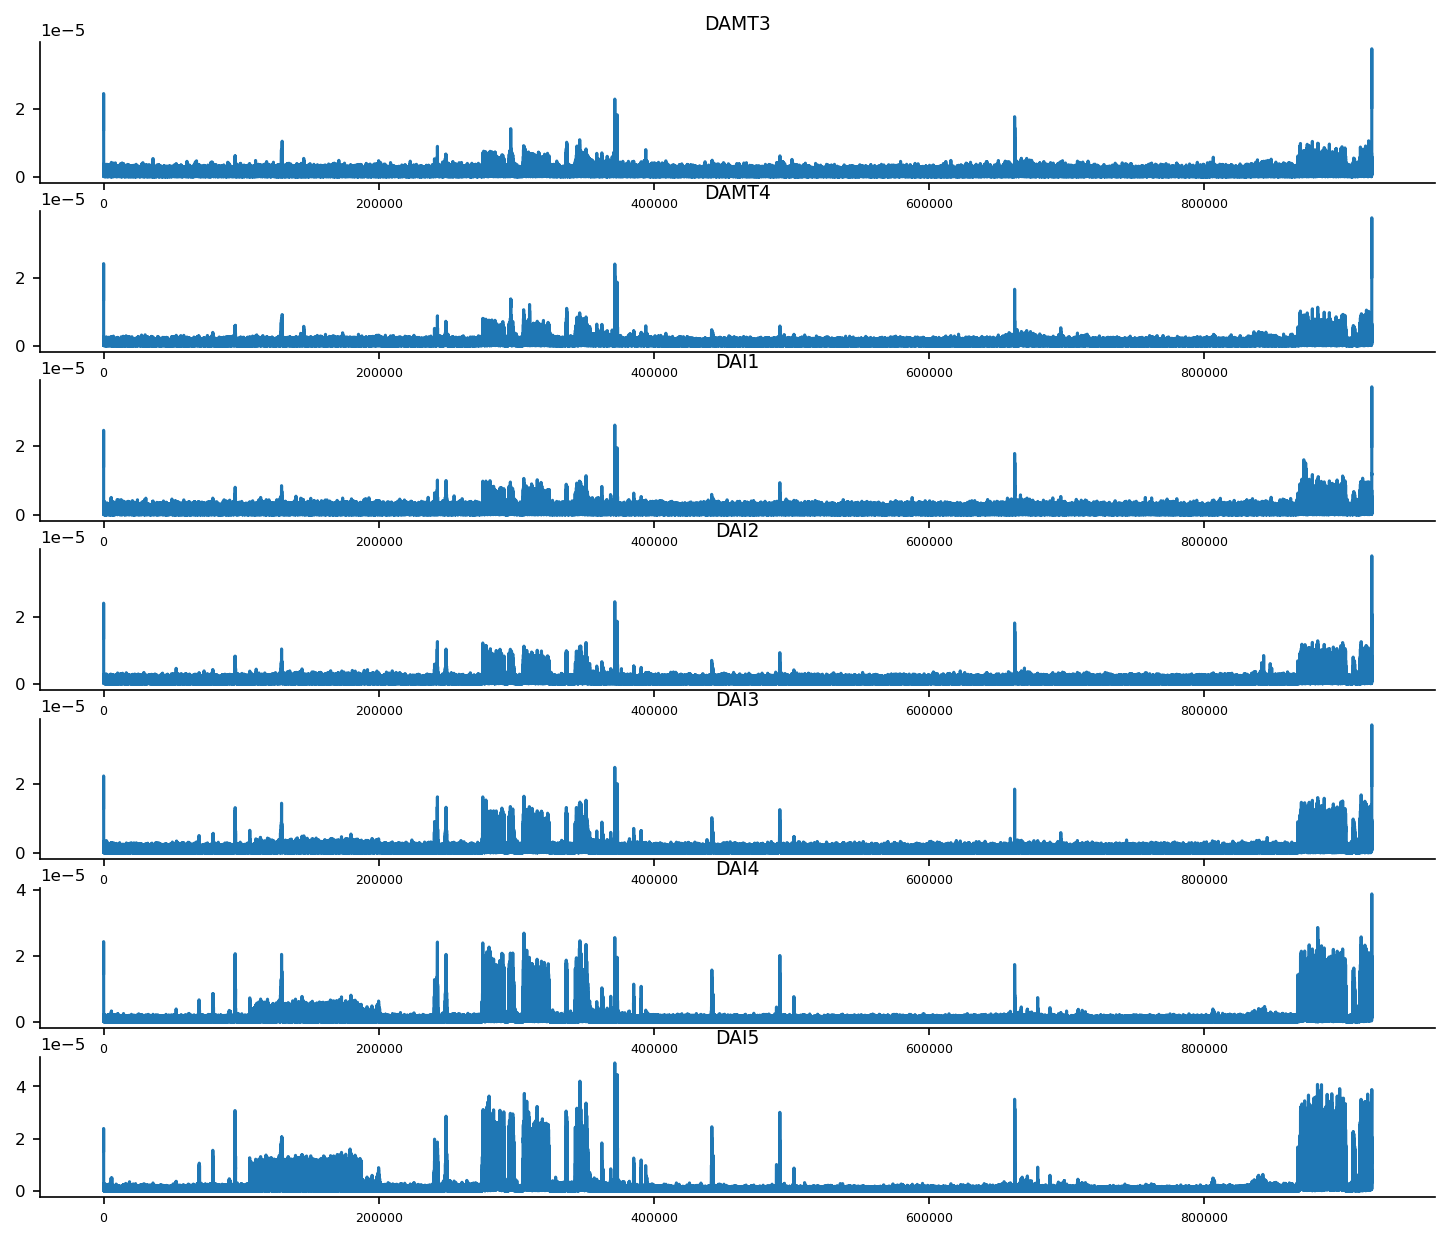

In [19]:
fig, axes = plt.subplots(len(ecog_data), 1, figsize=(12, 10))
for i, ax in enumerate(axes):
    ax.set_title(channels2[i])
    ax.plot(ecog_data[i])
fig.show()